In [1]:
import torch
import torch.nn as nn 
import torchvision.transforms as T
from torchvision.datasets.mnist import MNIST 
from torch.utils.data import DataLoader
import numpy as np 
from torch.optim import Adam

In [2]:
# first step of viT is to define the patches of the image and then flatten them for the next step 

class Patch_embedding(nn.Module):

    def __init__(self, dim ,  image_size , patch_size , channels): 
        super().__init__()
        self.dim = dim 
        self.p_size = patch_size
        self.i_size = image_size
        self.channels = channels

        self.linear_projection = nn.Conv2d(self.channels , self.dim , kernel_size=self.p_size , stride=self.p_size)

    def forward(self , x): 

        x = self.linear_projection(x)
        x = x.contiguous() # original = (B , C, H , W) ---> patched = (B , dim, P , P)
        x = x.flatten(2) # (B , dim , P , P) ----> (B , dim , P)
        x = x.transpose(1,2)
        x = x.contiguous() # (B, dim , P) ---> (B , p , dim)
        
        return x 



In [3]:
# second step is positional embedding 
class Positional_embedding(nn.Module): 
    def __init__(self,  dim , max_size_embed): 
        super().__init__()
        self.classifier_token = nn.Parameter(torch.randn(1, 1, dim)) # defined a classifier token 

        pe = torch.zeros(max_size_embed , dim)

        for pos in range(max_size_embed):
            for i in range(dim): 
                 if i % 2 == 0:
                     pe[pos][i] = np.sin(pos/(10000 ** (i/dim))) # derived from formula 
                 else:
                    pe[pos][i] = np.cos(pos/(10000 ** ((i-1)/dim))) # same above 
        self.register_buffer('pe' , pe.unsqueeze(0)) # adds the pe to buffer 

    def forward(self , x ): 

        token = self.classifier_token.expand(x.size()[0] , -1 , -1) # changes the dimension of classifier_token from  ( 1, 1, dim) --- > (B , 1, dim)
        x = torch.cat((token,x) , dim =1 ) # adds the token and x i.e (B , 1 dim) + ( B , N , dim) ---> (B , N+1 , dim) which mean that an additonal classifier token is added 
        x = x + self.pe 
        
        return x 





In [4]:
#basic attention model 


class AttentionHead(nn.Module):
  def __init__(self, d_model, head_size):
    super().__init__()
    self.head_size = head_size

    self.query = nn.Linear(d_model, head_size)
    self.key = nn.Linear(d_model, head_size)
    self.value = nn.Linear(d_model, head_size)

  def forward(self, x):
    # Obtaining Queries, Keys, and Values
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    # Dot Product of Queries and Keys
    attention = Q @ K.transpose(-2,-1)

    # Scaling
    attention = attention / (self.head_size ** 0.5)

    attention = torch.softmax(attention, dim=-1)

    attention = attention @ V

    return attention


In [5]:
# uses multiple single head attentions for mulitple questions as per queries 


class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    self.head_size = d_model // n_heads

    self.W_o = nn.Linear(d_model, d_model)

    self.heads = nn.ModuleList([AttentionHead(d_model, self.head_size) for _ in range(n_heads)])

  def forward(self, x):
    # Combine attention heads
    out = torch.cat([head(x) for head in self.heads], dim=-1)
    out = out.contiguous()
    out = self.W_o(out)

    return out

In [6]:
# reference from the diagram in "Attention is all you need" simple encoder block 

class Encoder(nn.Module):
  def __init__(self, d_model, n_heads, r_mlp=4):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads

    # Sub-Layer 1 Normalization
    self.ln1 = nn.LayerNorm(d_model)

    # Multi-Head Attention
    self.mha = MultiHeadAttention(d_model, n_heads)

    # Sub-Layer 2 Normalization
    self.ln2 = nn.LayerNorm(d_model)

    # Multilayer Perception
    self.mlp = nn.Sequential(
        nn.Linear(d_model, d_model*r_mlp),
        nn.GELU(),
        nn.Linear(d_model*r_mlp, d_model)
    )

  def forward(self, x):
    # Residual Connection After Sub-Layer 1
    out = x + self.mha(self.ln1(x))

    # Residual Connection After Sub-Layer 2
    out = out + self.mlp(self.ln2(out))

    return out

In [7]:
class VisionTransformer(nn.Module):
  def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()

    assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
    assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

    self.d_model = d_model # Dimensionality of model
    self.n_classes = n_classes # Number of classes
    self.img_size = img_size # Image size
    self.patch_size = patch_size # Patch size
    self.n_channels = n_channels # Number of channels
    self.n_heads = n_heads # Number of attention heads

    self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
    self.max_seq_length = self.n_patches + 1

    self.patch_embedding = Patch_embedding(self.d_model, self.img_size, self.patch_size,  self.n_channels)
    self.positional_encoding = Positional_embedding( self.d_model, self.max_seq_length)
    self.transformer_encoder = nn.Sequential(*[Encoder( self.d_model, self.n_heads) for _ in range(n_layers)])

    # MLP
    self.classifier = nn.Sequential(
        nn.Linear(self.d_model, self.n_classes),
        nn.Softmax(dim=-1)
    )

  def forward(self, images):
    x = self.patch_embedding(images)

    x = self.positional_encoding(x)

    x = self.transformer_encoder(x)
    
    x = self.classifier(x[:,0])

    return x

In [8]:
d_model = 9
n_classes = 10
img_size = (32,32)
patch_size = (16,16)
n_channels = 1
n_heads = 3
n_layers = 3
batch_size = 128
epochs = 20
alpha = 0.005

In [9]:
transform = T.Compose([
  T.Resize(img_size),
  T.ToTensor()
])

train_set = MNIST(
  root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
  root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

tensor(7)

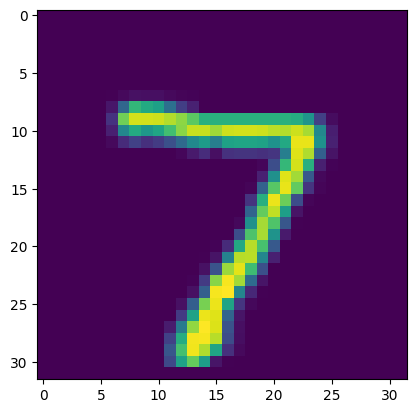

In [10]:
import  matplotlib.pyplot as plt
#checking the dataloader 
img , label = next(iter(test_loader))
plt.imshow(img[0].squeeze()) 
label[0]



In [11]:
device = torch.device('cpu')

In [12]:
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
crit= nn.CrossEntropyLoss()

In [13]:
import csv


train_losses = []
train_accuracies = []

for epoch in range(epochs):
    training_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        image, label = data
        image, label = image.to(device), label.to(device)
        
        optimizer.zero_grad()

   
        op = transformer(image)
        

        loss = crit(op, label)
        loss.backward()
        optimizer.step()


        training_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(op, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()


    epoch_loss = training_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Print epoch loss and accuracy
    print(f'Epoch {epoch + 1}/{epochs} ------------------------- Loss: {epoch_loss:.3f}  Accuracy: {epoch_accuracy:.2f}%')

    # Save to log file after every epoch
    with open('training_log.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        if epoch == 0:  # Write headers on the first epoch
            writer.writerow(['Epoch', 'Loss', 'Accuracy'])
        writer.writerow([epoch + 1, epoch_loss, epoch_accuracy])




Epoch 1/20 ------------------------- Loss: 1.818  Accuracy: 64.46%
Epoch 2/20 ------------------------- Loss: 1.708  Accuracy: 75.27%
Epoch 3/20 ------------------------- Loss: 1.650  Accuracy: 81.03%
Epoch 4/20 ------------------------- Loss: 1.639  Accuracy: 82.14%
Epoch 5/20 ------------------------- Loss: 1.629  Accuracy: 83.12%
Epoch 6/20 ------------------------- Loss: 1.569  Accuracy: 89.24%
Epoch 7/20 ------------------------- Loss: 1.543  Accuracy: 91.80%
Epoch 8/20 ------------------------- Loss: 1.540  Accuracy: 92.17%
Epoch 9/20 ------------------------- Loss: 1.533  Accuracy: 92.84%
Epoch 10/20 ------------------------- Loss: 1.534  Accuracy: 92.70%
Epoch 11/20 ------------------------- Loss: 1.529  Accuracy: 93.15%
Epoch 12/20 ------------------------- Loss: 1.528  Accuracy: 93.27%
Epoch 13/20 ------------------------- Loss: 1.528  Accuracy: 93.34%
Epoch 14/20 ------------------------- Loss: 1.523  Accuracy: 93.78%
Epoch 15/20 ------------------------- Loss: 1.523  Accura

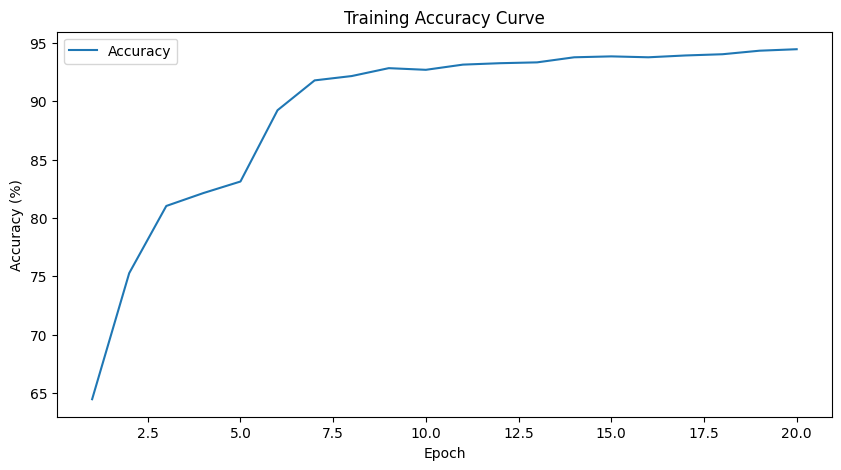

In [16]:

# Plot the accuracy curve after training is complete
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

In [15]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)

    outputs = transformer(images)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    for i in range(len(predicted)):
      print(f"prediction: {predicted[i]} ----> actual: {labels[i]}")
    correct += (predicted == labels).sum().item()
  print(f'\nModel Accuracy: {100 * correct // total} %')

prediction: 7 ----> actual: 7
prediction: 2 ----> actual: 2
prediction: 1 ----> actual: 1
prediction: 0 ----> actual: 0
prediction: 4 ----> actual: 4
prediction: 1 ----> actual: 1
prediction: 4 ----> actual: 4
prediction: 9 ----> actual: 9
prediction: 5 ----> actual: 5
prediction: 9 ----> actual: 9
prediction: 0 ----> actual: 0
prediction: 6 ----> actual: 6
prediction: 9 ----> actual: 9
prediction: 0 ----> actual: 0
prediction: 1 ----> actual: 1
prediction: 5 ----> actual: 5
prediction: 9 ----> actual: 9
prediction: 7 ----> actual: 7
prediction: 8 ----> actual: 3
prediction: 4 ----> actual: 4
prediction: 9 ----> actual: 9
prediction: 6 ----> actual: 6
prediction: 6 ----> actual: 6
prediction: 5 ----> actual: 5
prediction: 4 ----> actual: 4
prediction: 0 ----> actual: 0
prediction: 7 ----> actual: 7
prediction: 4 ----> actual: 4
prediction: 0 ----> actual: 0
prediction: 1 ----> actual: 1
prediction: 3 ----> actual: 3
prediction: 1 ----> actual: 1
prediction: 3 ----> actual: 3
prediction